In [1]:
from datasets import DatasetDict, ClassLabel, Dataset
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback
from transformers import (
  AutoConfig,
  AutoTokenizer,
  AutoModelForSequenceClassification
)
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import random
import pandas as pd
import evaluate
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import classification_report
import numpy as np

In [2]:
ruta = './data/Silver/data_for_trainning_encoder.parquet'

df = pd.read_parquet(ruta)


###subset aleatorio pero manteniendo proporcion de busqueda mercadona-hacendado
# n = 4308
# df['sentimiento_producto'] =df['sentimiento_producto'].astype(str).str.strip()
# df_balanceado = (df.groupby('sentimiento_producto', group_keys=False).apply(lambda x: x.sample(n=n//2, random_state=69)))

# df = df_balanceado


In [3]:
df['sentimiento_final'].value_counts()

sentimiento_final
negativo    5266
positivo    3775
neutral      957
Name: count, dtype: int64

In [4]:
##balancear el dataset, downsampling egativos.

# Aseguramos que no haya espacios
df['sentimiento_final'] = df['sentimiento_final'].astype(str).str.strip()

# Calculamos cuántos queremos por clase
target_neg = int(3775)
target_pos = int(3775)
target_neu = int(957)

# Función para muestrear por 'busqueda' manteniendo proporciones internas
def stratified_sample(df_class, target_size):
    return (
        df_class.groupby('sentimiento_final', group_keys=False)
                .apply(lambda x: x.sample(
                    n=int(len(x) / len(df_class) * target_size),
                    random_state=69
                ))
    )

# Separar clases
df_neg = stratified_sample(df[df['sentimiento_final'] == 'negativo'], target_neg)
df_pos = stratified_sample(df[df['sentimiento_final'] == 'positivo'], target_pos)
df_neu = stratified_sample(df[df['sentimiento_final'] == 'neutral'], target_neu)

# Unir y mezclar
df_balanceado = pd.concat([df_neg, df_pos, df_neu]).sample(frac=1, random_state=69).reset_index(drop=True)


/tmp/ipykernel_45526/2144144966.py:15: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(
/tmp/ipykernel_45526/2144144966.py:15: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(
/tmp/ipykernel_45526/2144144966.py:15: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns w

In [5]:
df_balanceado['search'].value_counts()

search
mercadona    4281
hacendado    4226
Name: count, dtype: int64

In [6]:
df = df_balanceado.copy()

In [7]:
df['sentimiento_final'].value_counts()

sentimiento_final
positivo    3775
negativo    3775
neutral      957
Name: count, dtype: int64

In [8]:
df.columns

Index(['index', 'User', 'tweets', 'search', 'fecha_captura',
       'explica_sentimiento', 'explica_sentimiento_2', 'sentimiento_final',
       'proteccion_datos', 'deteccion_producto', 'producto',
       'sentimiento_producto', 'categoria', 'comparativa_producto',
       'comparativa_sentimiento', 'imagen_marca'],
      dtype='object')

In [10]:


nombre_modelo_nuevo= 'Joan_Roig_twitter_sentiment'



In [11]:
df_for_training = df[['tweets', 'sentimiento_final']].copy()

df_for_training = df_for_training.rename(columns={'tweets': 'text', 'sentimiento_final':'labels' })
df_for_training['labels'] = (df_for_training['labels']
                              .astype(str)
                              .str.strip()
                              .map({'positivo': 1, 'negativo': 0, 'neutral':2}))
df_for_training

,text,labels
0,Que se eduque a los hijos del labrador y del b...,1
1,"- “primo, tu cuantas veces follas en el día?” ...",1
2,hijos de puta ingresadme la nomina @Mercadona,0
3,Le dije a mi madre que me gustaba la tortilla ...,0
4,Mi clase inicial será Cajera del Mercadona. Y ...,1
...,...,...
8502,Hacendado gana de nuevo,1
8503,#mercadona por qué han quitado la carne de keb...,0
8504,- Hoy me he levantado hacendado.\n- ¿Que parec...,1
8505,#FirstDates421 #anuncios Ay la leche que se va...,1


In [12]:
dataset = Dataset.from_pandas(df_for_training)
dataset

Dataset({
    features: ['text', 'labels'],
    num_rows: 8507
})

In [13]:
model_name = 'Twitter/twhin-bert-large'  
tokenizer = AutoTokenizer.from_pretrained(model_name)


def preprocess_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True)


dataset = dataset.map(preprocess_function, batched=True) 


Map:   0%|          | 0/8507 [00:00<?, ? examples/s]

Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [14]:
# 1. División inicial: 90% train+dev, 10% test
split_1 = dataset.train_test_split(test_size=0.1, shuffle=True, seed=42)

# 2. División secundaria: de ese 90%, separamos 11.11% para validación  (10% del total original)
split_2 = split_1['train'].train_test_split(test_size=0.1111, shuffle=True, seed=69)


final_splits = DatasetDict({
    'train': split_2['train'],
    'validation': split_2['test'],
    'test': split_1['test']
})

# Verificación de tamaños
print(f"Train: {len(final_splits['train'])}")
print(f"Validation: {len(final_splits['validation'])}")
print(f"Test: {len(final_splits['test'])}")

Train: 6805
Validation: 851
Test: 851


In [15]:
from collections import Counter

def print_label_distribution(split_name, dataset):
    labels = dataset['labels']
    total = len(labels)
    counter = Counter(labels)
    print(f"Distribución en {split_name} (total {total}):")
    for label, count in counter.items():
        print(f"  Clase {label}: {count} ({count/total:.2%})")
    print()

print_label_distribution('Train', final_splits['train'])
print_label_distribution('Validation', final_splits['validation'])
print_label_distribution('Test', final_splits['test'])

Distribución en Train (total 6805):
  Clase 1: 3017 (44.34%)
  Clase 0: 3020 (44.38%)
  Clase 2: 768 (11.29%)

Distribución en Validation (total 851):
  Clase 1: 385 (45.24%)
  Clase 2: 95 (11.16%)
  Clase 0: 371 (43.60%)

Distribución en Test (total 851):
  Clase 0: 384 (45.12%)
  Clase 1: 373 (43.83%)
  Clase 2: 94 (11.05%)



In [16]:
dataset = final_splits

In [17]:
SEED = 69

def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(SEED)



id2label = {0: "negativo", 1: "positivo", 2:'neutral'}
label2id = {"negativo": 0, "positivo": 1, "neutral":2}

#device_map custom
device_map = {
    # Embeddings en CUDA:0 
    "bert.embeddings": "cuda:0",
    
    # Primeras 7 capas en CUDA:0
    "bert.encoder.layer.0": "cuda:0",
    "bert.encoder.layer.1": "cuda:0", 
    "bert.encoder.layer.2": "cuda:0",
    "bert.encoder.layer.3": "cuda:0",
    "bert.encoder.layer.4": "cuda:0",
    "bert.encoder.layer.5": "cuda:0",
    "bert.encoder.layer.6": "cuda:0",
    "bert.encoder.layer.7": "cuda:0",
    "bert.encoder.layer.8": "cuda:0",

    # Resto de capas (20 capas) en CUDA:1 - la mayoría del modelo
    **{f"bert.encoder.layer.{i}": "cuda:1" for i in range(9, 24)},
    
    # Pooler y classifier en CUDA:0 (para facilitar el output)
    "bert.pooler": "cuda:0",
    "classifier": "cuda:0"
}


def model_init():
    return AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=3,
    id2label=id2label,
    label2id=label2id,
    device_map=device_map, #"auto",


    trust_remote_code=True,

    #hacer dropout
    # #hiden modelo eurobert
    # hidden_dropout=0.1,
    # attention_dropout=0.1,

    #hiden modelo roberta

    # hidden_dropout_prob=0.1,  # dropout en capas ocultas cuando se activa afecta a la cabeza de clasificacion
    # attention_probs_dropout_prob=0.1,  # dropout en atención
    #classifier_dropout=0.3,     # dropout en clasificación para ajustar solamente la cabeza.

    )

model = model_init()
print(model.config)


# # imprimir layers entrenables
for name, param in model.named_parameters():
  print(name, param.requires_grad)

print(100*("="))
print('dropout')
# Verificar  dropout
for name, module in model.named_modules():
    if isinstance(module, torch.nn.Dropout):
        print(f"{name}: {module}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at Twitter/twhin-bert-large and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "id2label": {
    "0": "negativo",
    "1": "positivo",
    "2": "neutral"
  },
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "label2id": {
    "negativo": 0,
    "neutral": 2,
    "positivo": 1
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "position_embedding_type": "relative_key",
  "torch_dtype": "float32",
  "transformers_version": "4.53.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 250002
}

bert.embeddings.word_embeddings.weight True
bert.embeddings.position_embeddings.weight True
bert.embeddings.token_type_embeddings.weight True
bert.embeddings.LayerNorm.weight True
bert.embeddings.LayerNorm.bias True
bert.encoder.layer.

In [18]:
#NO-MODIFY: VARIABLE NAME
training_args =  TrainingArguments(
    output_dir=nombre_modelo_nuevo,
    learning_rate= 6e-05 , ### 2e-5  [1e-5, 1e-6, 1e-5,  2e-5, 3e-5, 1e-4 ] de minimos locales a no converger # 2e-5 estandar
    per_device_train_batch_size=16, #8
    per_device_eval_batch_size=16, #8
    num_train_epochs= 15,
    weight_decay=0.1,
    eval_strategy="steps",
    #save_strategy="steps",
    save_strategy="best",
    save_total_limit=3,
    eval_steps=10, 
    logging_strategy="steps",
    logging_steps=20, 
    load_best_model_at_end=True,
    push_to_hub=False,
    report_to="none",
    seed=SEED,
    metric_for_best_model="f1_weighted",
    greater_is_better=True,
    #bf16=True, #
    full_determinism=True,
    gradient_accumulation_steps = 64 #
)

In [19]:
accuracy = evaluate.load("accuracy")
f1_score = evaluate.load("f1")

#compute metrics multiclase
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    # Accuracy (funciona igual para multiclase)
    accuracy_value = accuracy.compute(predictions=predictions, references=labels)["accuracy"]

    # acro F1 (promedio no ponderado de F1 por clase)
    f1_macro = f1_score.compute(predictions=predictions, references=labels, average="macro")["f1"]

    #  Micro F1 (equivale a accuracy en multiclase)
    f1_micro = f1_score.compute(predictions=predictions, references=labels, average="micro")["f1"]

    #  Weighted F1 (promedio ponderado por soporte de cada clase)
    f1_weighted = f1_score.compute(predictions=predictions, references=labels, average="weighted")["f1"]

    return {
        "accuracy": accuracy_value,
        "f1_macro": f1_macro,
        "f1_micro": f1_micro,
        "f1_weighted": f1_weighted,
    }


In [20]:
#funcion custom de perdida para clases no balanceadas.
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback
from typing import Optional, Dict, Any

class FocalLoss(nn.Module):
    """
    Focal Loss implementation para datos desbalanceados
    Args:
        alpha: Lista de pesos por clase o valor único
        gamma: Factor de enfoque (default: 2.0)
        reduction: 'mean', 'sum' or 'none'
    """
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        if isinstance(alpha, list):
            self.alpha = torch.tensor(alpha, dtype=torch.float32)
        else:
            self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        # Si inputs viene del modelo de transformers
        if hasattr(inputs, 'logits'):
            logits = inputs.logits
        else:
            logits = inputs

        # Calcular cross entropy
        ce_loss = F.cross_entropy(logits, targets, reduction='none')
        pt = torch.exp(-ce_loss)

        # Aplicar focal loss
        focal_loss = (1 - pt) ** self.gamma * ce_loss

        if self.alpha is not None:
            if isinstance(self.alpha, torch.Tensor):
                if self.alpha.device != targets.device:
                    self.alpha = self.alpha.to(targets.device)
                alpha_t = self.alpha[targets]
                focal_loss = alpha_t * focal_loss
            else:
                focal_loss = self.alpha * focal_loss

        # Aplicar reducción
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

class SimpleFocalTrainer(Trainer):
    """Versión simple que solo necesita cambiar la clase Trainer"""
    def __init__(self, focal_gamma=2.0, focal_alpha=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.focal_loss = FocalLoss(alpha=focal_alpha, gamma=focal_gamma)

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        loss = self.focal_loss(outputs, labels)
        return (loss, outputs) if return_outputs else loss


# Calcular automáticamente los alphas.
def calculate_alpha_for_focal(labels):
    unique, counts = np.unique(labels, return_counts=True)
    total = len(labels)
    n_classes = len(unique)

    alphas = []
    for count in counts:
        alpha = total / (n_classes * count)
        alphas.append(round(alpha, 3))

    return alphas

train_labels = dataset['train']['labels']
alphas = calculate_alpha_for_focal(train_labels)
print(f"focal_alpha = {alphas}")

focal_alpha = [np.float64(0.751), np.float64(0.752), np.float64(2.954)]


/tmp/ipykernel_45526/3651019345.py:66: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `SimpleFocalTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Step,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Micro,F1 Weighted
10,No log,0.345732,0.616921,0.575251,0.616921,0.630489
20,0.358600,0.290388,0.658049,0.628976,0.658049,0.671993
30,0.358600,0.309169,0.682726,0.650743,0.682726,0.696491
40,0.184800,0.343457,0.701528,0.667130,0.701528,0.707617
50,0.184800,0.446799,0.739130,0.702187,0.739130,0.740275
60,0.087700,0.491461,0.753231,0.720354,0.753231,0.753804
70,0.087700,0.595468,0.745006,0.709702,0.745006,0.747566
80,0.043700,0.633627,0.752056,0.710873,0.752056,0.752583
90,0.043700,0.631545,0.747356,0.710524,0.747356,0.748722


{'eval_loss': 0.6315454840660095, 'eval_accuracy': 0.7473560517038778, 'eval_f1_macro': 0.7105239168054331, 'eval_f1_micro': 0.7473560517038778, 'eval_f1_weighted': 0.748721653977119, 'eval_runtime': 3.0877, 'eval_samples_per_second': 275.61, 'eval_steps_per_second': 17.489, 'epoch': 12.901408450704226}


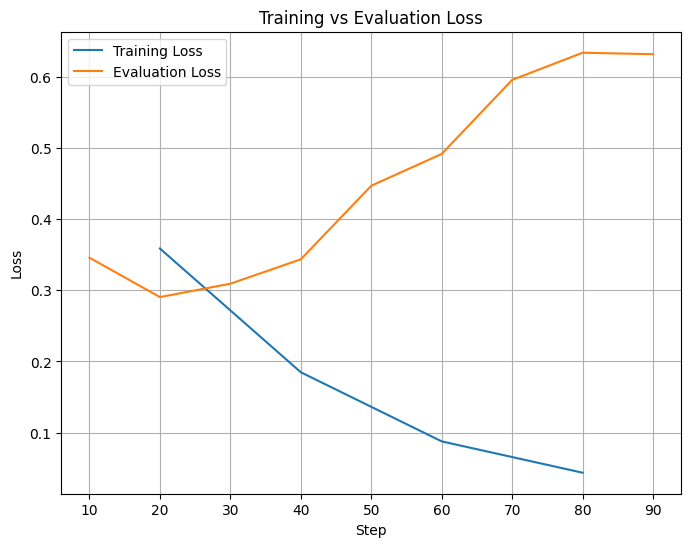

In [21]:
trainer = SimpleFocalTrainer(
    focal_gamma= 2.0,  ## ajustar según necesites
    focal_alpha=alphas, # # =None ## calculo automatico pesos para cada clase = alphas
    model=model,
    args=training_args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['validation'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)



trainer.train()
metrics = trainer.evaluate()
print(metrics)


# Extraemos los logs de entrenamiento
history = pd.DataFrame(trainer.state.log_history)

# A veces los logs pueden tener pasos donde no se evalúa. Filtramos filas con 'loss' y 'eval_loss'
train_loss = history[history['loss'].notna()][['step', 'loss']]
eval_loss = history[history['eval_loss'].notna()][['step', 'eval_loss']]

# Plot
plt.figure(figsize=(8, 6))
plt.plot(train_loss['step'], train_loss['loss'], label='Training Loss')
plt.plot(eval_loss['step'], eval_loss['eval_loss'], label='Evaluation Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training vs Evaluation Loss')
plt.legend()
plt.grid(True)
plt.show()


In [22]:
metrics = trainer.evaluate()
print(metrics)

{'eval_loss': 0.6315454840660095, 'eval_accuracy': 0.7473560517038778, 'eval_f1_macro': 0.7105239168054331, 'eval_f1_micro': 0.7473560517038778, 'eval_f1_weighted': 0.748721653977119, 'eval_runtime': 3.0562, 'eval_samples_per_second': 278.45, 'eval_steps_per_second': 17.669, 'epoch': 12.901408450704226}


In [23]:
### estas son las metricas que estoy cogiendo.
trainer.evaluate(dataset['test'])

{'eval_loss': 0.8327097296714783,
 'eval_accuracy': 0.7685076380728555,
 'eval_f1_macro': 0.7129306664039151,
 'eval_f1_micro': 0.7685076380728555,
 'eval_f1_weighted': 0.7700982813964602,
 'eval_runtime': 3.6256,
 'eval_samples_per_second': 234.718,
 'eval_steps_per_second': 14.894,
 'epoch': 12.901408450704226}

metricas
{'test_loss': 0.8327097296714783, 'test_accuracy': 0.7685076380728555, 'test_f1_macro': 0.7129306664039151, 'test_f1_micro': 0.7685076380728555, 'test_f1_weighted': 0.7700982813964602, 'test_runtime': 3.5689, 'test_samples_per_second': 238.451, 'test_steps_per_second': 15.131}
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.82      0.82       384
           1       0.79      0.77      0.78       373
           2       0.51      0.57      0.54        94

    accuracy                           0.77       851
   macro avg       0.71      0.72      0.71       851
weighted avg       0.77      0.77      0.77       851



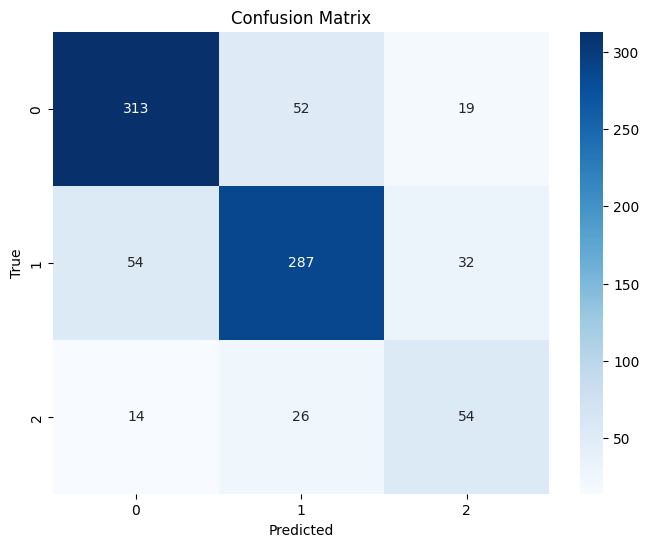

In [24]:
### Crear una matriz de confusión
# Obtener predicciones
predicciones_trainer = trainer.predict(dataset['test'])

print("metricas")
print(predicciones_trainer.metrics)

# Las predicciones pueden venir como logits, necesitamos el argmax
y_pred = np.argmax(predicciones_trainer.predictions, axis=1)
# Etiquetas verdaderas
y_true = predicciones_trainer.label_ids
cm = confusion_matrix(y_true, y_pred)

print("Classification Report:")
print(classification_report(y_true, y_pred))

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [25]:
# import os
# from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, DataCollatorWithPadding

# checkpoint_path = "Joan_Roig_twitter_sentiment/checkpoint-60"

# # Verificar archivos
# print("Archivos en el checkpoint:")
# if os.path.exists(checkpoint_path):
#     files = os.listdir(checkpoint_path)
#     for file in files:
#         print(f"  - {file}")

#     # Cargar modelo
#     model = AutoModelForSequenceClassification.from_pretrained(checkpoint_path)   
#     tokenizer = AutoTokenizer.from_pretrained(checkpoint_path)
#     # Data collator
#     data_collator = DataCollatorWithPadding(tokenizer=tokenizer)    
#     # Trainer
#     trainer = Trainer(
#         model=model,
#         args=training_args,
#         eval_dataset=dataset['validation'],
#         tokenizer=tokenizer,
#         data_collator=data_collator,
#         compute_metrics=compute_metrics
#     )
#     # Evaluar
#     metrics = trainer.evaluate()
#     print(metrics)
    
# else:
#     print(f"La ruta {checkpoint_path} no existe")

In [26]:
### estas son las metricas que estoy cogiendo.
trainer.evaluate(dataset['test'])

{'eval_loss': 0.8327097296714783,
 'eval_accuracy': 0.7685076380728555,
 'eval_f1_macro': 0.7129306664039151,
 'eval_f1_micro': 0.7685076380728555,
 'eval_f1_weighted': 0.7700982813964602,
 'eval_runtime': 3.4694,
 'eval_samples_per_second': 245.288,
 'eval_steps_per_second': 15.565,
 'epoch': 12.901408450704226}

metricas
{'test_loss': 0.8327097296714783, 'test_accuracy': 0.7685076380728555, 'test_f1_macro': 0.7129306664039151, 'test_f1_micro': 0.7685076380728555, 'test_f1_weighted': 0.7700982813964602, 'test_runtime': 3.585, 'test_samples_per_second': 237.381, 'test_steps_per_second': 15.063}
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.82      0.82       384
           1       0.79      0.77      0.78       373
           2       0.51      0.57      0.54        94

    accuracy                           0.77       851
   macro avg       0.71      0.72      0.71       851
weighted avg       0.77      0.77      0.77       851



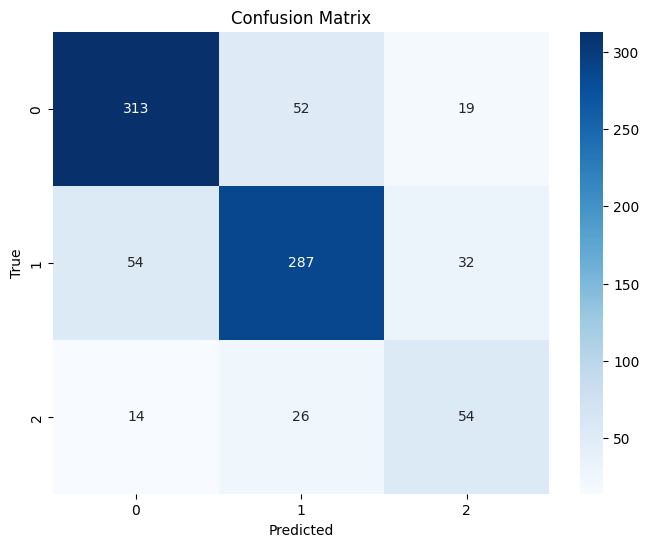

In [27]:
### Crear una matriz de confusión
# Obtener predicciones
predicciones_trainer = trainer.predict(dataset['test'])

print("metricas")
print(predicciones_trainer.metrics)

# Las predicciones pueden venir como logits, necesitamos el argmax
y_pred = np.argmax(predicciones_trainer.predictions, axis=1)
# Etiquetas verdaderas
y_true = predicciones_trainer.label_ids
cm = confusion_matrix(y_true, y_pred)

# print("Confusion Matrix:")
# print(cm)

print("Classification Report:")
print(classification_report(y_true, y_pred))

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [28]:
# from huggingface_hub import login
# login(token="hf_")
# trainer.push_to_hub(nombre_modelo_nuevo)